# Playing around with Quasars

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import vstack

import collections
import numpy as np
import healpy as hp

import pymaster as nmt


In [2]:
def bin_z(cat, edges):
    edges_full = [0.] + list(edges) + [1E300]  #David's better version
    cat_bin = [cat[(cat['Z']>=edges_full[i]) & (cat['Z']<edges_full[i+1])]
               for i in range(len(edges)+1)]
    return cat_bin

In [4]:
def make_map(field, random):
    nside = 512
    
    field_ra = np.radians(field['RA'].values) #Phi
    field_dec = np.radians(field['DEC'].values) #Pi/2 - dec = theta
    random_ra = np.radians(random['RA'].values) 
    random_dec = np.radians(random['DEC'].values) 
    
    field_FKP = np.array(field['WEIGHT_FKP'].values) 
    field_SYSTOT = np.array(field['WEIGHT_SYSTOT'].values) 
    field_CP = np.array(field['WEIGHT_CP'].values) 
    field_NOZ = np.array(field['WEIGHT_NOZ'].values)
    field_data = field_SYSTOT*field_CP*field_NOZ #FKP left out
    
    random_FKP = np.array(random['WEIGHT_FKP'].values) 
    random_SYSTOT = np.array(random['WEIGHT_SYSTOT'].values) 
    random_CP = np.array(random['WEIGHT_CP'].values) 
    random_NOZ = np.array(random['WEIGHT_NOZ'].values)
    random_data = random_SYSTOT*random_CP*random_NOZ
    
    field_indices = hp.ang2pix(nside, np.pi/2 - field_dec, field_ra) #pixel_indecis
    random_indices = hp.ang2pix(nside, np.pi/2 - random_dec, random_ra)  
    
    field_pixel_data = np.bincount(field_indices, field_data, hp.nside2npix(nside)) 
                                                                        #for each pixel in the resolution, 
                                                                        #Adds all the data entries that 
                                                                        #have been assigned the such pixel
    random_pixel_data = np.bincount(random_indices, random_data, hp.nside2npix(nside))
    
    alpha = sum(field_pixel_data)/sum(random_pixel_data)
    
    pixel_density_data = np.zeros(hp.nside2npix(nside))
    goodpix = random_pixel_data > 0   #avoid dividing by 0
    pixel_density_data[goodpix] = field_pixel_data[goodpix]/(alpha*random_pixel_data[goodpix]) - 1
    
    # The maps are: delta, mask, mean_number
    return np.array([pixel_density_data, random_pixel_data, random_pixel_data*alpha])
    
   

Load the data

In [5]:
#NGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
#NGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
#SGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
#SGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
prefix = '/home/zcapjru/PhD/Data/'
prefix = './'
NGC =  fits.open(prefix + 'eBOSS_QSO_clustering_data-NGC-vDR16.fits')
NGC_r =  fits.open(prefix + 'eBOSS_QSO_clustering_random-NGC-vDR16.fits')
SGC =  fits.open(prefix + 'eBOSS_QSO_clustering_data-SGC-vDR16.fits')
SGC_r =  fits.open(prefix + 'eBOSS_QSO_clustering_random-SGC-vDR16.fits')

Information about data

In [6]:
cols = NGC_r[1].columns
cols.info()

name:
    ['RA', 'DEC', 'Z', 'WEIGHT_FKP', 'WEIGHT_SYSTOT', 'WEIGHT_CP', 'WEIGHT_NOZ', 'NZ']
format:
    ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
unit:
    ['', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '']
bscale:
    ['', '', '', '', '', '', '', '']
bzero:
    ['', '', '', '', '', '', '', '']
disp:
    ['', '', '', '', '', '', '', '']
start:
    ['', '', '', '', '', '', '', '']
dim:
    ['', '', '', '', '', '', '', '']
coord_type:
    ['', '', '', '', '', '', '', '']
coord_unit:
    ['', '', '', '', '', '', '', '']
coord_ref_point:
    ['', '', '', '', '', '', '', '']
coord_ref_value:
    ['', '', '', '', '', '', '', '']
coord_inc:
    ['', '', '', '', '', '', '', '']
time_ref_pos:
    ['', '', '', '', '', '', '', '']


From fits to pandas and then to maps

In [7]:
NGC_table =   Table.read(NGC)
NGC_r_table =  Table.read(NGC_r)
SGC_table =   Table.read(SGC)
SGC_r_table = Table.read(SGC_r)

/home/alonso/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
NGC_data = NGC_table.to_pandas()
NGC_r_data = NGC_r_table.to_pandas()
SGC_data = SGC_table.to_pandas()
SGC_r_data = SGC_r_table.to_pandas()

bin data

In [9]:
%%time
binned_NGC   = bin_z(NGC_data, [1.5])
binned_NGC_r = bin_z(NGC_r_data, [1.5])
binned_SGC   = bin_z(SGC_data, [1.5])
binned_SGC_r = bin_z(SGC_r_data, [1.5])

CPU times: user 576 ms, sys: 108 ms, total: 684 ms
Wall time: 681 ms


Thread and map

In [10]:
%%time
NGC_maps = []
for i in range(len(binned_NGC)):
    NGC_maps.append(make_map(binned_NGC[i],binned_NGC_r[i] ))
    
SGC_maps = []
for i in range(len(binned_SGC)):
    SGC_maps.append(make_map(binned_SGC[i],binned_SGC_r[i] ))

CPU times: user 4.96 s, sys: 162 ms, total: 5.12 s
Wall time: 5.12 s


Add NGC and SGC 

In [11]:
#Structure: [field, mask]
Whole_maps_1 = SGC_maps[0] + NGC_maps[0]
Whole_maps_2 = SGC_maps[1] + NGC_maps[1]

Plot

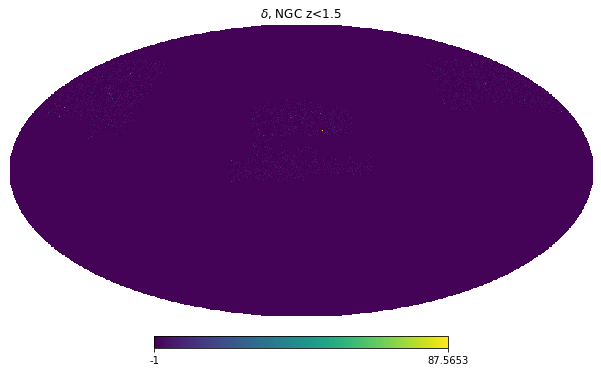

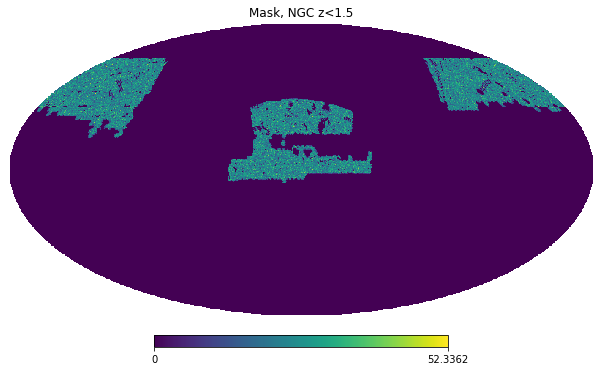

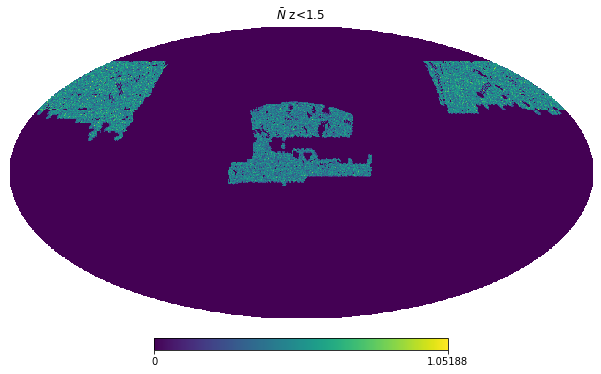

In [12]:
hp.visufunc.mollview(Whole_maps_1[0], title= r'$\delta$, NGC z<1.5')
hp.visufunc.mollview(Whole_maps_1[1], title= r'Mask, NGC z<1.5')
hp.visufunc.mollview(Whole_maps_1[2], title= r'$\bar{N}$ z<1.5')


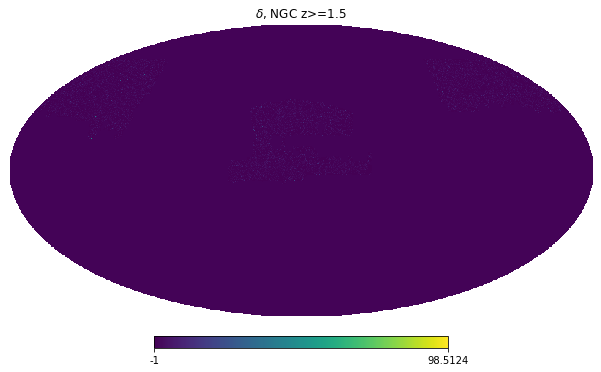

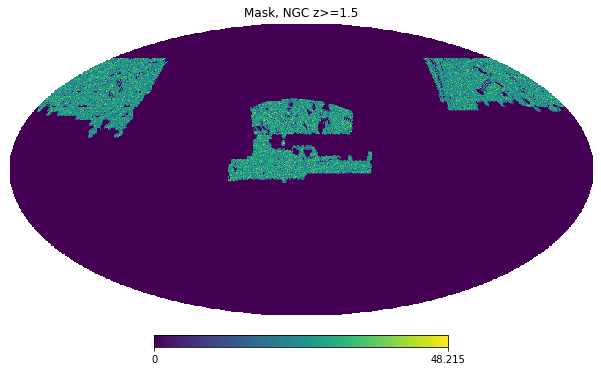

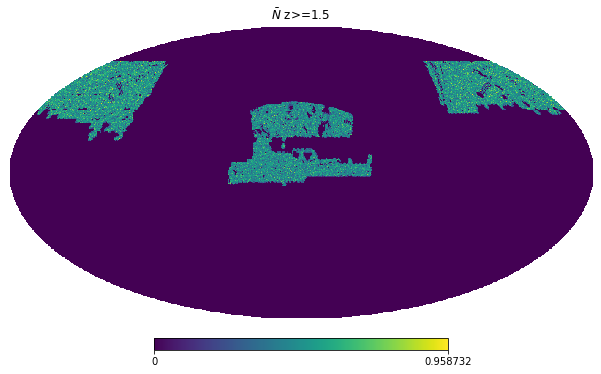

In [13]:
hp.visufunc.mollview(Whole_maps_2[0], title= r'$\delta$, NGC z>=1.5')
hp.visufunc.mollview(Whole_maps_2[1], title= r'Mask, NGC z>=1.5')
hp.visufunc.mollview(Whole_maps_2[2], title= r'$\bar{N}$ z>=1.5')


Make fields

In [14]:
# Read healpix maps and initialize a spin-0 and spin-2 field
f_1 = nmt.NmtField(Whole_maps_1[1], [Whole_maps_1[0]])
f_2 = nmt.NmtField(Whole_maps_2[1], [Whole_maps_2[0]])

Make band powers

In [15]:
# Initialize binning scheme with 20 ells per bandpower
nside = hp.npix2nside(len(Whole_maps_1[0]))
b = nmt.NmtBin.from_nside_linear(nside, 20)

Create Workspace ---> get mode coupling matrix

In [16]:
w_11 = nmt.NmtWorkspace()
w_11.compute_coupling_matrix(f_1, f_1, b)

w_12 = nmt.NmtWorkspace()
w_12.compute_coupling_matrix(f_1, f_2, b)

w_22 = nmt.NmtWorkspace()
w_22.compute_coupling_matrix(f_2, f_2, b)

Make Cl's using the coupling matrices

In [17]:
def compute_naive_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [18]:
cl_11 = compute_naive_cl(f_1, f_1, w_11)
cl_12 = compute_naive_cl(f_1, f_2, w_12)
cl_22 = compute_naive_cl(f_2, f_2, w_22)

### Remove Poisson noise

In [20]:
def coupled_nl_2(mask, n):
    #Assumptions:
    #1) noise is uncorrelated such that the two sums over
    #pixels collapse into one --> True for poisson noise
    #2) Pixel area is a constant --> True for healpy
    
    #Input:
    #mask --> mask 
    #n --> map with mean number of galaxies per pixel 
    
    nside = hp.npix2nside(len(mask))
    pixel_A = 4*np.pi/hp.nside2npix(nside)

    sum_items = np.zeros(hp.nside2npix(nside))
    goodpix = n > 0   #avoid dividing by 0
    sum_items[goodpix] = (mask[goodpix]**2/n[goodpix])

    #David's notes formula
    N_ell = pixel_A*np.mean(sum_items)
        
    #Following Carlos code
    return np.array([N_ell * np.ones(3*nside)])

In [21]:
nl_11 = w_11.decouple_cell(coupled_nl_2(Whole_maps_1[1], Whole_maps_1[2]))
nl_22 = w_22.decouple_cell(coupled_nl_2(Whole_maps_2[1], Whole_maps_2[2]))

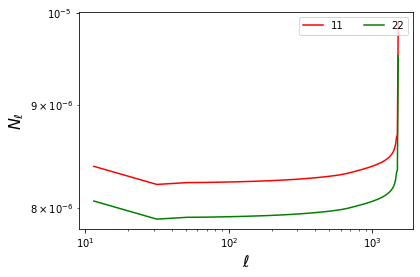

In [22]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, nl_11[0], 'r-', label='11')
plt.plot(ell_arr, nl_22[0], 'g-', label='22')

plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$N_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

In [23]:
cl_11_no_noise = cl_11-nl_11
cl_12_no_noise = cl_12
cl_22_no_noise = cl_22-nl_22

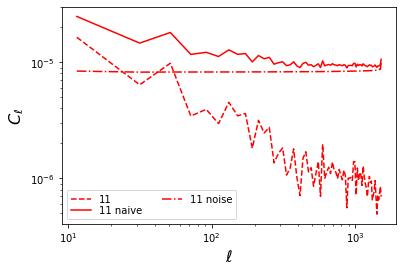

In [24]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_11_no_noise[0], 'r--', label='11')
plt.plot(ell_arr, cl_11[0], 'r-', label='11 naive')
plt.plot(ell_arr, nl_11[0], 'r-.', label='11 noise')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

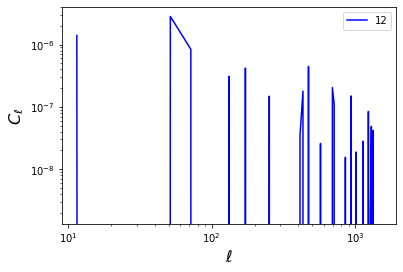

In [25]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_12[0], 'b-', label='12')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

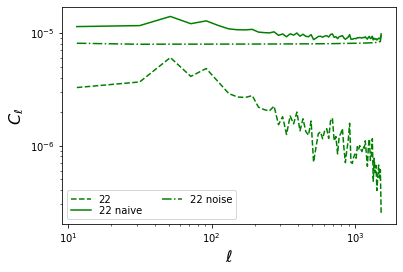

In [26]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_22_no_noise[0], 'g--', label='22')
plt.plot(ell_arr, cl_22[0], 'g-', label='22 naive')
plt.plot(ell_arr, nl_22[0], 'g-.', label='22 noise')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()